# _Notebook Jupyter_ 8_prediçãoRisco

# Predição do Risco dada uma Importação

O objetivo agora é dada uma importação contendo **kit de transmissão de motocicletas** fazer a sua classificação e em seguida apresentar uma análise de risco visual baseada na estatística existente de outras importações.<br>
É importante salientar que esta análise não substitui a acurada análise a ser realizada por um Auditor Fiscal, tendo em vista que o resultado será uma lista de parâmetros objetivos que indicarão graus de observação para o gerenciamento de risco.
Desse modo, a entrada será o registro de importação contendo todos os campos. A função determinará a classificação e com base nos valores declarados de outras importações da mesma classificação, fará a comparação analítica com o valor da importação em análise.

## Importando bibliotecas

In [1]:
import pandas as pd, time
import pickle
# Vetorização
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Modelos
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn import metrics
# Divisor de Treino/Treste
from sklearn.model_selection import train_test_split
# Matplot
import matplotlib.pyplot as plt

In [2]:
# importa funções criadas no módulo 3_classificarAplicação.ipynb (criarModelo.py)
from funcoesTCC import *
# Funções: criaModelo, limpaDescricao, achaPalavraChave, pegaChave, acrescentaMarca, retentorAux
# Variávis: stopwords, palavrasChave, Marcas
# Datasets: dftemp (Aplicações)

In [3]:
# Data e hora da execução do script
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 11/01/2022 às 14:34


## Treinamento do Classificador Linear SVC

Pela velocidade, versatilidade, facilidade de uso e, obviamente, a acurácia, optou-se pelo modelo do classificador Linear SVC.

In [4]:
# Importa base de dados com os modelos já determinados para um dataframe
df = pd.read_excel(r'./bases/dataframe_modelos_classificado.xlsx')
# Criação da função CountVectorizer
cvt = CountVectorizer(strip_accents='ascii', lowercase=True)
X_cvt = cvt.fit_transform(df['Modelo'])
# Criação da função TfidfTransformer
tfi = TfidfTransformer(use_idf=True)
X_tfi = tfi.fit_transform(X_cvt)


# A entrada será a transformação de vetores com a normalização tf-idf
#entrada = X_tfi
# A saida será as aplicações
#saida = df['APLICACAO']
# Separando 1% dos dados para teste
#X_train, X_test, y_train, y_test = train_test_split(entrada, saida, test_size=0.01)


# Como o modelo já foi testado, utilizaremos todo a base como treinamento
X_train=X_tfi.toarray()
y_train=np.array(df['APLICACAO'])

# Criando modelo
clfsvc = LinearSVC()
# Treinamento do modelo
clfsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Importando a Tabela ABIMOTO

In [5]:
dfABIMOTO = pd.read_excel(r'./bases/dfABIMOTOv13.xlsx')

In [6]:
dfABIMOTO.sample()

,ITEM,PARTES E PEÇAS,MOTO PARTS,NCM,UNI,VMLE,RETENTOR
14,92,KIT TRANSMISSÃO XTZ - 250 LANDER COM RETENTOR,TRANSMISSION SET + H CHAIN 250 LANDER,87141000,KIT,8.2,True


##### Função de classificação LinearSVC

In [7]:
def classificaAplicacaoSVC(modelo):
    novo_cvt = cvt.transform(pd.Series(modelo))
    novo_tfi = tfi.transform(novo_cvt)
    aplicacao = clfsvc.predict(novo_tfi)[0]
    return aplicacao

In [8]:
descricao = df.iloc[13454]['DESCRICAO DO PRODUTO'] 
# verifica a descrição do produto
descricao

'KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 160 TITAN (16-19)/ CG 160 FAN (16-19) / CG 160 START (16-19)/ CG 160 CARGO (16-19), COMPOSTO DE CORRENTE 428 X SM118 + COROA S40307 44Z + PINHAO 25111 15Z (CERTIFICADO NR.BR31512'

In [9]:
classificaAplicacaoSVC(criaModelo(descricao))

'HONDA CG TIT TITAN 125 150 160'

#### Classificando a Tabela ABIMOTO

In [10]:
dfABIMOTO['APLICACAO']=dfABIMOTO['PARTES E PEÇAS'].apply(classificaAplicacaoSVC)

In [11]:
dfABIMOTO.sample()

,ITEM,PARTES E PEÇAS,MOTO PARTS,NCM,UNI,VMLE,RETENTOR,APLICACAO
2,80,KIT TRANSMISSÃO 1045 (CORRENTE.COROA. PINHAO) ...,TRANS.SET 1045 (CHAIN + SPROCKET) CBX 250 TWISTER,87141000,KIT,9.3,True,HONDA TWISTER CBX 250


#### Função de busca do valor da Aplicação na Tabela ABIMOTO

In [12]:
def achaValorABIMOTO(aplicacao, retentor):
    dfABtemp=dfABIMOTO[dfABIMOTO['APLICACAO']==aplicacao]
    dfABtemp=dfABtemp[dfABtemp['RETENTOR']==retentor]
    if dfABtemp.shape[0]==0:
        return 0
    return min(dfABtemp['VMLE'])

##### Define linha exemplo (PODE APAGAR AO FINAL)

In [13]:
dfimp=df.sample(50)
dfimp.sample()

,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS.OR,PAIS DE ORIGEM,PAIS.AQ,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,...,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO,DESCRICAO,Modelo,APLICACAO,RETENTOR
12975,819950000200010,202102,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",160,"CHINA, REPUBLICA POP",10,QUILOGRAMA LIQUIDO,...,1785.0,N/INFORMADO,ITAJAI,FOB,EFETIVA,DI DESEMBARAÇADA,crosser 150 14,CROSSER 150,YAMAHA XTZ CROSSER 150,False


## Função de determinação do risco

Os valores _outliers_ foram removidos segundo o parâmetro de distância interquartílica, dado pela expressão da imagem abaixo:

Apesar da bibliografia indicar o uso de uma vez e meia o intervalo entre o primeiro e o terceiro quartil para definir os _outliers_, optou-se nesse trabalho, por uma questão de segurança, em utilizar o valor de três vezes.

https://estatsite.com.br/2018/12/01/localizando-outliers-atraves-do-intervalo-interquartil-boxplot-codigo-sas/

In [14]:
def plotrisco(Q, valor,valorABIMOTO=0):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    # cria o plot
    fig, ax = plt.subplots(figsize=(10, 1.25))
    # define os dados sequenciais, posição e cores
    ax.broken_barh([(0,Q[0]),(Q[0],Q[1]), (Q[1],Q[11]), (Q[11],Q[3]), (Q[3],Q[4]), (Q[4],Q[5]),
                             (Q[5],Q[6]), (Q[6],Q[7]), (Q[7],Q[8]), (Q[8],Q[9]), (Q[9],Q[10])], 
                    [10, 9], 
                   facecolors=('#c10000', 'r', 'r','#fdff01', '#00fe32', '#02ff00', 
                               '#02ff00','#02ff00', '#00fe32','#00fe32', '#006dff'))
    # define limites dos eixos x e y
    ax.set_ylim(10,15)
    ax.set_xlim(Q[0], Q[10])
    # define os marcadores dos eixos
    ax.set_yticks([])
    ax.set_xticks([Q[11],Q[5],Q[9]])
    ax.set_axisbelow(True)
    # define os textos
    #ax.text((Q[0]+Q[1])/2, 14, "Q10%", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[1], 15.5, "Q10%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[1], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
 
    ax.text(Q[11], 15.5, "Q25%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[11], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[5], 15.5, "Q50%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[5], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[12], 15.5, "Q75%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[12], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[9], 15.5, "Q90%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[9], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[10], 15.5, "Q100%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[10], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    # o valor (Q[10]-Q[0])/40 relativiza a escala na hora de mover algo no gráfico.
    undrelativa = (Q[10]-Q[0])/40
    ax.text(Q[0]-1*undrelativa, 12.5, f"Min({Q[0]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    ax.text((Q[5]), 8, "Mediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[10]+1*undrelativa, 12.5, f"Máx({Q[10]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    # define alertas
    alerta=''
    # alerta quando valor fora dos limites máximo e mínimo
    if valor<Q[0] or valor>Q[10]:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} fora dos limites do modelo (outlier)."
        alerta+='\n'
    if valorABIMOTO>valor:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} menor que referência mínima ABIMOTO: USD{valorABIMOTO:.2f}."
    ax.text((Q[10]+Q[0])/2, 6, alerta, fontsize=16, color='r', verticalalignment='center', horizontalalignment='center')
    # define o título
    fig.suptitle('Previsão de Risco', fontsize=16, y=1.5, horizontalalignment='center')
    # cores do ponteiro
    cores=['#a20000','#ff6900', '#007d00', '#00007d'] # vermelho, amarelo, verde, azul
    # condições para determinar a cor do ponteiro
    if   valor>=Q[9]: cor=cores[3]
    elif valor>=Q[3]: cor=cores[2]
    elif valor>=Q[11]: cor=cores[1]
    else:             cor=cores[0]
    # plota o ponteiro e o valor
    ax.scatter(x=valor, y=10.9, marker='v', c=cor, s=400)
    ax.text(valor, 12.2, valor, color='black', fontsize=14, verticalalignment='center', horizontalalignment='center')
    ax.vlines(x=Q[5], ymin=10, ymax=15)
    # se existir valor na tabela ABIMOTO
    if valorABIMOTO>0:
        ax.scatter(x=valorABIMOTO, y=10.7, marker='v', c='black', s=200)
        if valorABIMOTO>valor:
            ax.text(valorABIMOTO+1*undrelativa, 10.6, f'{valorABIMOTO:.2f}(ABIMOTO)', color='black', fontsize=12, verticalalignment='center', horizontalalignment='left')
        else:
            ax.text(valorABIMOTO-1*undrelativa, 10.6, f'(ABIMOTO){valorABIMOTO:.2f}', color='black', fontsize=12, verticalalignment='center', horizontalalignment='right')
    # mostra o gráfico
    plt.show()

In [15]:
def riscoValor(dfimp):
    import matplotlib.pyplot as plt
    p=67 # repetições dos - nos prints
    # dfimp será uma série ou dataframe pandas contendo as importações a analisar
    # caso tenha mais de uma linha, será iterada sobre todas as linhas.
    if type(dfimp)==type(pd.Series([])):    tipo='s' # tipo series
    if type(dfimp)==type(pd.DataFrame([])): tipo='d' # tipo dataframe
    if not(tipo=='s' or tipo=='d'): # se o tipo não for séries ou dataframe
        raise TypeError('É preciso entrar com um dataframe ou uma Series do pandas.')
    if tipo=='d': # se for do tipo dataframe
        for i, linha in dfimp.iterrows(): # executa a função novamente para cada linha (series)
            riscoValor(linha) # reexecuta para cada linha se fornecido um dataframe
    elif tipo=='s': # se o tipo for uma series executa a rotina
        print('\x1b[1;31m'+'RELATÓRIO DE RISCO'+'\x1b[0m')
        #print(p*'-')
        print('\x1b[1;31m'+'\nDados da Declaração de Importação'+'\x1b[0m')
        descricao=dfimp['DESCRICAO DO PRODUTO']
        origem=dfimp['PAIS DE ORIGEM']
        retentor=retentorAux(dfimp['DESCRICAO DO PRODUTO'])
        retentortexto="com retentor" if retentor else "sem retentor"
        aplicacao=classificaAplicacaoSVC(criaModelo(descricao))
        valor=round(dfimp['VALOR UN.PROD.DOLAR'],2)
        valorABIMOTO=achaValorABIMOTO(aplicacao, retentor)
        print(f'Descrição: {descricao}\n'+
              f'Origem:    {origem}\n'+
              f'Retentor:  {retentortexto}\n'+
              f'Aplicação: {aplicacao}\n'+
              f'Valor DI:  USD {valor:.2f}')
        if valorABIMOTO>0: print(f'Tabela de Referência ABIMOTO\nValor:      USD {valorABIMOTO:.2f}\n')
        # filtra o df somente para os registros da aplicação classificda
        dfrisco=df[df['APLICACAO']==aplicacao] # filtra para a aplicação
        dfrisco=dfrisco[dfrisco['RETENTOR']==retentor] # filtra para a existência de retentor
        # remove os valores discrepantes dos dados
        # filtra somente valores de Q25-discrepancia*(Q75-Q25) a Q75+*discrepancia*(Q75-Q25)
        discrepancia=3 # valor padrão=1.5 
        Q25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        Q75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        min=Q25-discrepancia*(Q75-Q25)
        max=Q75+discrepancia*(Q75-Q25)
        filtro=[min<=dfrisco['VALOR UN.PROD.DOLAR']] and [dfrisco['VALOR UN.PROD.DOLAR']<=max]
        dfrisco=dfrisco[filtro[0]]
        # recálculo dos quartis 25 e 75 para df sem outliers
        Q25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        Q75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        # geração da lista com os quartis
        Q=[round(np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],x),2) for x in range(0,110,10)]+[round(Q25,2),round(Q75,2)]
        estatisticas=dfrisco.describe()['VALOR UN.PROD.DOLAR']
        estatisticas.rename(index={'count':'qtd de registros:','mean':'média simples:','std':'desvio padrão:','min':'valor mínimo:','25%':'percentil 25%:','50%':'percentil 50%:','75%':'percentil 75%:','max':'valor máximo:'}, inplace=True)
        print('\x1b[1;31m'+f'Estatísticas:\n'+'\x1b[0m'+f'{estatisticas.to_string()}\n')
        # fazer um plot indicando a posição do valor em uma barra variando em vermelho-amarelo-verde-azul
        quartil={}
        for x in range(0,10): quartil[10+x*10] = Q[x]
        quartil[25]=Q25
        quartil[75]=Q75
        perc=[f'{chave}={quartil[chave]:.2f}' for chave in sorted(quartil.keys())]
        print('\x1b[1;31m'+f'Percentis:\n'+'\x1b[0m'+f'  {str(perc[:6])[1:-1]}\n  {str(perc[6:])[1:-1]}')
        print('\x1b[1;31m'+f'\nHistograma por Decil:'+'\x1b[0m')
        plt.figure(figsize=(10,5),frameon=False)
        plt.hist(dfrisco['VALOR UN.PROD.DOLAR'],10,rwidth=0.9,range=(Q[0],Q[10]))
        #plt.figure() .text((Q[5]), 8, "|\nMediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
        plt.show()
        print('\x1b[1;31m'+f'Previsão de Risco:'+'\x1b[0m')
        plotrisco(Q,valor,valorABIMOTO)
        print('\n\n')

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES SENDO, KIT DE TRANSMISSÃO TITANIUM ( 1045 ) PARA C 100 BIZ ( 98-05 ) / C 100 BIZ + ( 02-05 ) C/CORRENTE 428H X 108L, COROA 35Z, PINHÃO 15Z - ITEM 71782
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.83
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


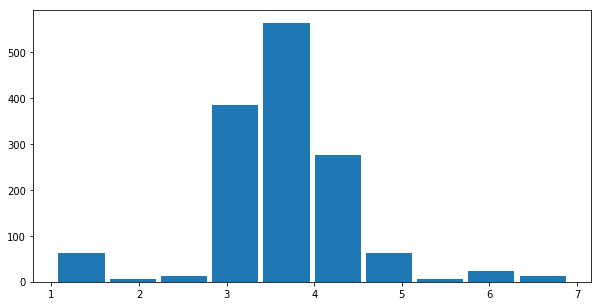

Previsão de Risco:


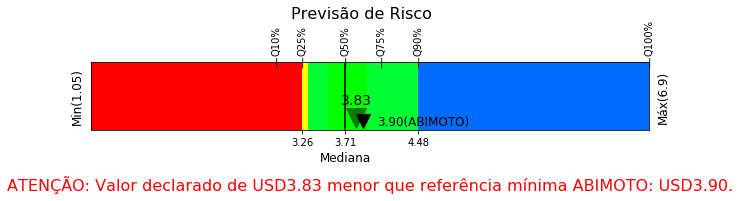

In [16]:
riscoValor(dfimp.iloc[0])

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETASCG 125 FAN (14-16)/ CG 125 CARGO (14-16)/ CG 125i FAN (16-18)/ CG125i CARGO (16-18), COMPOSTO DE CORRENTE 428 X SM118 +COROA S40282 43Z + PINHAO 25104 14Z (CERTIFICADO NR. BR31512030
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.07
Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'

Histograma por Decil:


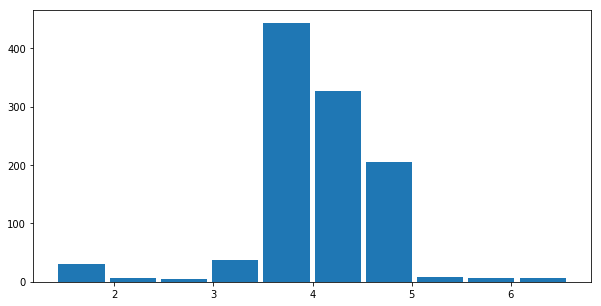

Previsão de Risco:


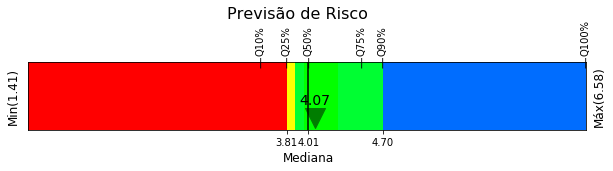




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: Ý20191/OR¨ KIT DE TRANSMISSÃO, EM AÇO 1045 TEMPERADO, COMPOSTO POR CORRENTE, COROA E PINHÃO, APLICAÇÃO: XTZ 250 LANDER - 1045 (46D/15D/428UOX130L), REF.: 20191/OR
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA LANDER XTZ 250
Valor DI:  USD 3.98
Tabela de Referência ABIMOTO
Valor:      USD 4.40

Estatísticas:
qtd de registros:    428.000000
média simples:         7.539407
desvio padrão:         3.493309
valor mínimo:          1.533400
percentil 25%:         4.440000
percentil 50%:         6.997000
percentil 75%:         9.933113
valor máximo:         17.473750

Percentis:
  '10=1.53', '20=3.94', '25=4.44', '30=4.35', '40=5.04', '50=6.48'
  '60=7.00', '70=8.25', '75=9.93', '80=8.75', '90=10.29', '100=11.34'

Histograma por Decil:


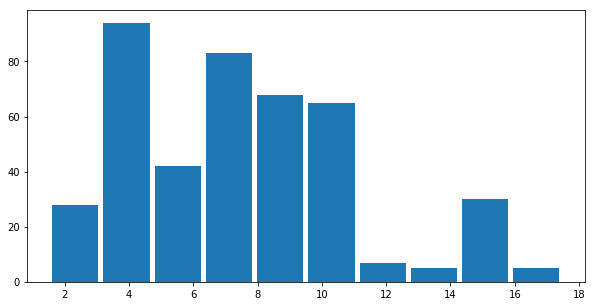

Previsão de Risco:


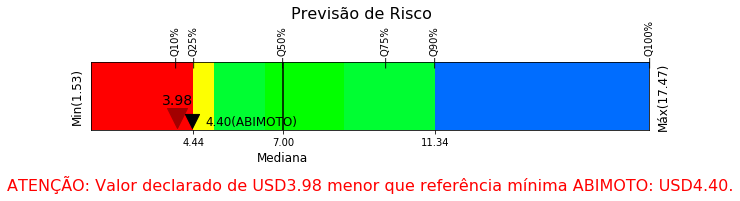




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CBX 250 TWISTER (01-08), COMPOSTO DE CORRENTE 520 X M136 + COROA 40067 37Z + PINHAO 25138 13Z - ITEM: 71761
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 6.86
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'

Histograma por Decil:


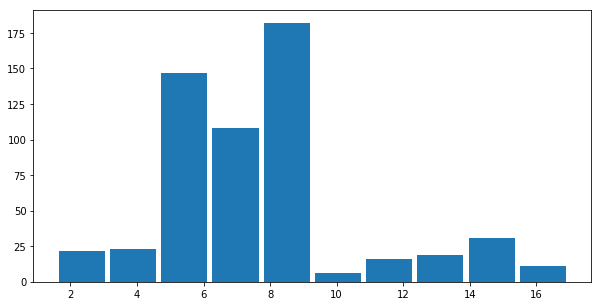

Previsão de Risco:


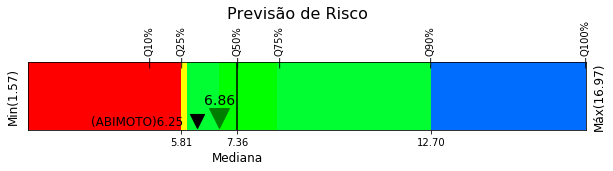




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT XTZ CROSSER 150 (ANO 2015/...) H 41*14 - KIT DE TRANSMISSAO COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: XTZ CROSSER 150 (ANO 2015/...), COROA/PINHAO: 41*14, CORRENTE DA MOTOCICLETA 428H E ELOS 122. REF. 55523C.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 3.27
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


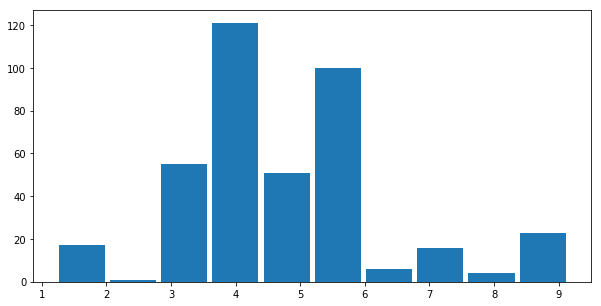

Previsão de Risco:


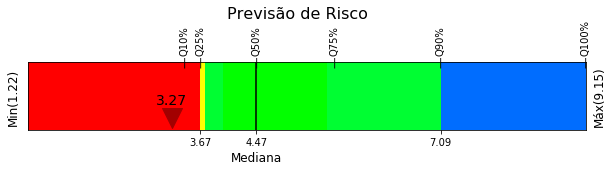




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530051 IN - KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: TITAN 160 15D/44D 428HX118L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.46
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


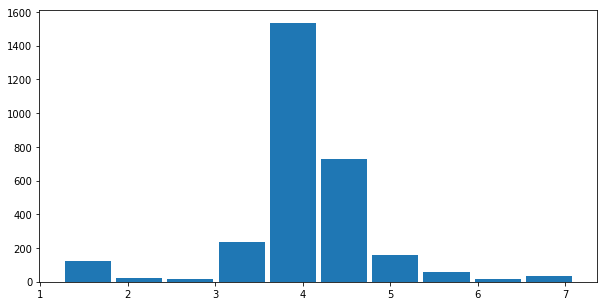

Previsão de Risco:


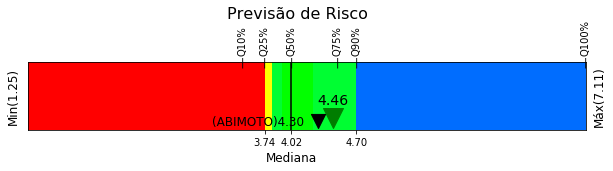




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 881800 - SEMI-KIT DE TRANSMISSAO COMPOSTO DE COROA E PINHAO, SEM CORRENTE, UTILIZADO NAS MOTOS XTZ150 CROSSER 14/19 - DENTES 41/14 - MARCA KMC-PRO
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 1.86
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


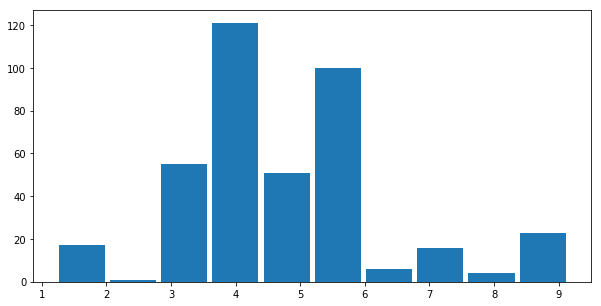

Previsão de Risco:


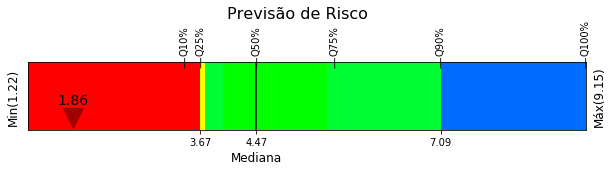




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 91177 KIT TRANSMISSAO TITANIUM PARA MOTOCICLETAS MODELO CG 160 TITAN (16-19) / CG 160 FAN (16-19) / CG 160 START (16-19) / CG 160 CARGO (16-19), COMPOSTO POR CORRENTE, COROA E PINHAO. CORRENTE FABRICADA EM AÇO, PERFIL: 428 REFORÇADA, 118 ELOS; COROA
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.71
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


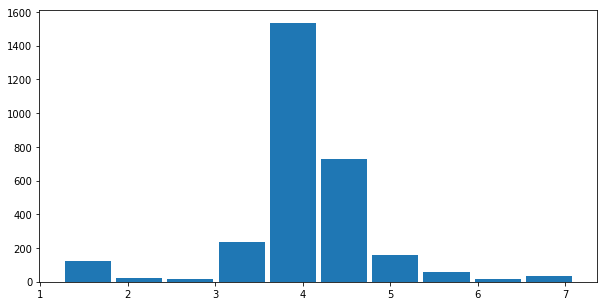

Previsão de Risco:


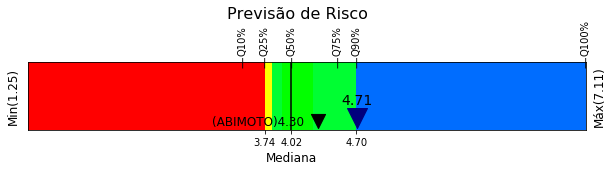




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSÃO EM AÇO 1045, COMPOSTO POR CORRENTE, COROA E PINHÃO, APLICAÇÃO: BIZ 125 (34T/14T/428H x 106L)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 2.89
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


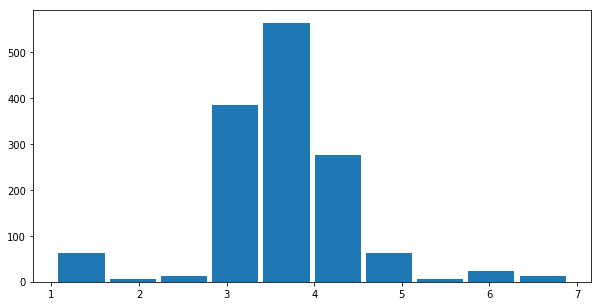

Previsão de Risco:


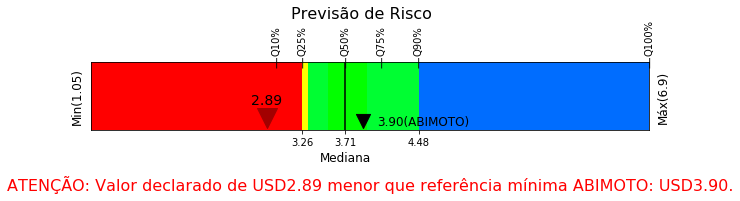




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: (10390/i45) KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO - KIT DE TRANSMISSAO EM ACO 1045 PARA USO EM MOTOCICLETA COMPOSTO POR CORRENTE, COROA E PINHAO, APLICACAO TITAN 00 (44T/14T/428H x 116L) MARCA SIVERST
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.82
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


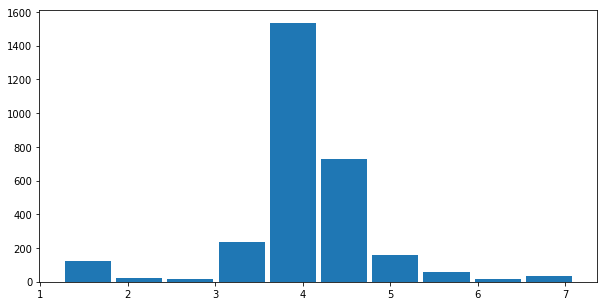

Previsão de Risco:


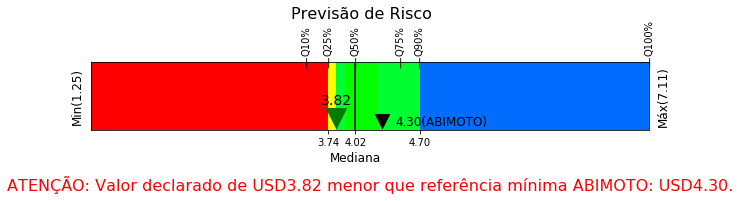




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TOP (1045) PARA MOTOCICLETAS XTZ 250 LANDER, COMPOSTO DE CORRENTE 428 X M353 + COROA 41612 46Z + PINHAO 26593 15Z (CERTIFICADO NR. BR31512030) - ITEM: 91093
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA LANDER XTZ 250
Valor DI:  USD 10.25
Tabela de Referência ABIMOTO
Valor:      USD 4.40

Estatísticas:
qtd de registros:    428.000000
média simples:         7.539407
desvio padrão:         3.493309
valor mínimo:          1.533400
percentil 25%:         4.440000
percentil 50%:         6.997000
percentil 75%:         9.933113
valor máximo:         17.473750

Percentis:
  '10=1.53', '20=3.94', '25=4.44', '30=4.35', '40=5.04', '50=6.48'
  '60=7.00', '70=8.25', '75=9.93', '80=8.75', '90=10.29', '100=11.34'

Histograma por Decil:


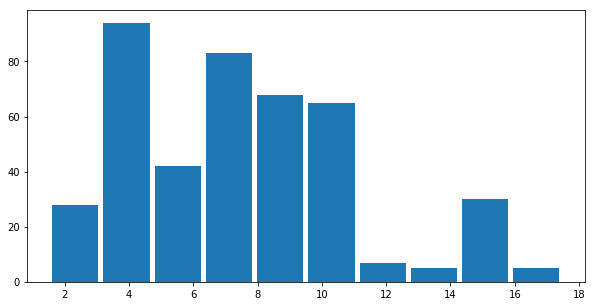

Previsão de Risco:


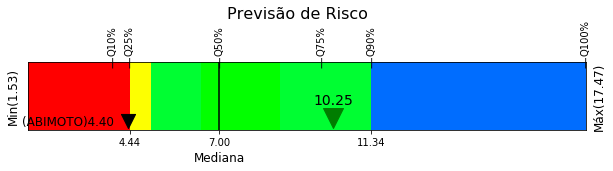




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT YBR 125 (ANO 2000/2002) H 43*14 - KIT DE TRANSMISSÃO COMPOSTO DE COROA/PINHÃO E CORRENTE PARA MODELO: YBR 125 (ANO 2000/2002) COROA/PINHÃO: 43*14, CORRENTE DA MOTOCICLETA 428H E ELOS 118.REF. 55517C.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.74
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


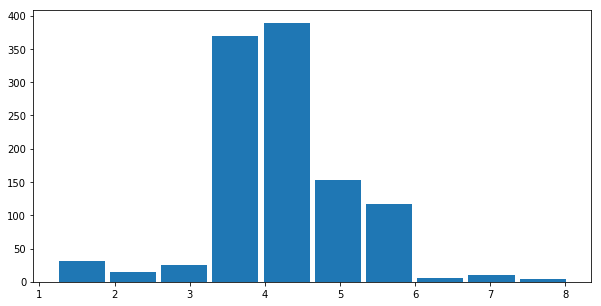

Previsão de Risco:


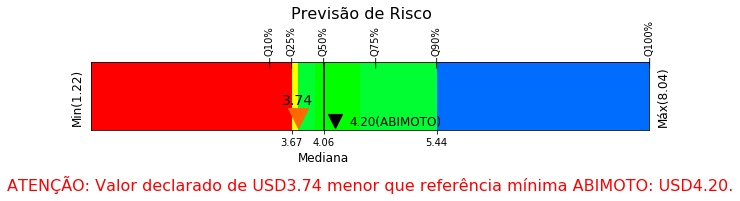




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: REF.: 001-P21B-02300, KIT TRANSMISSÃO COMPOSTO DE CORRENTE, COROA E PINHÃO - 1045 - 41D x 14D 428H x 126L STD, PARA MOTOCICLETAS MODELO YS FAZER 150 2014.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS150 150
Valor DI:  USD 4.04
Estatísticas:
qtd de registros:    428.000000
média simples:         4.645564
desvio padrão:         1.244155
valor mínimo:          1.106700
percentil 25%:         3.763200
percentil 50%:         4.598000
percentil 75%:         5.654700
valor máximo:          7.800000

Percentis:
  '10=1.11', '20=3.46', '25=3.76', '30=3.69', '40=3.84', '50=4.19'
  '60=4.60', '70=5.12', '75=5.65', '80=5.49', '90=5.68', '100=5.83'

Histograma por Decil:


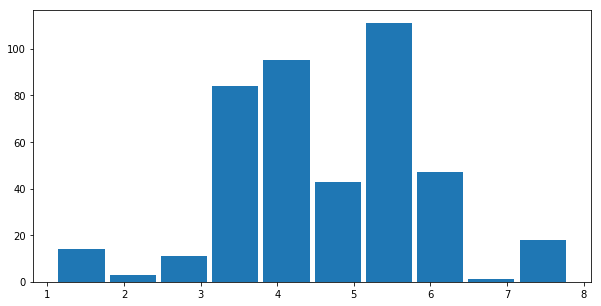

Previsão de Risco:


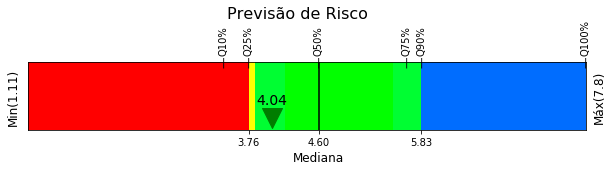




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 71827 KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO PARA MOTOCICLETAS, MODELO CG 150 TITAN (04-15) / CG 150 FAN (09-15) / CG 150 START (14-15) / CG 150 CARGO (14-15) 43Z X 16Z COM CORRENTE 428H X 118L - TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.61
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


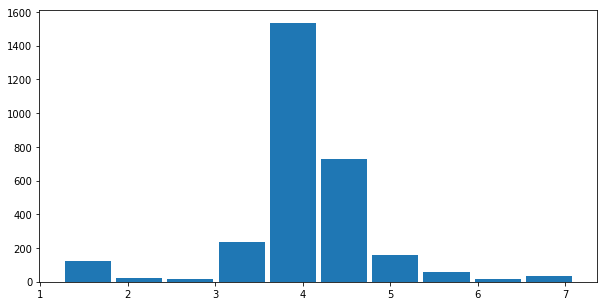

Previsão de Risco:


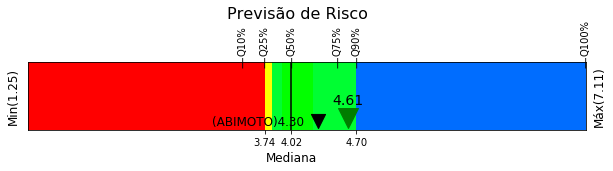




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item .16;Partes e peças para Motocicletas,Destaque 002-kit de Transmissão composto de corrente,coroa e pinhão;Tipo:1045-56Dx14D 428Hx124L STD;p/modelo:XLS 125 97-02;Nas Qdes:400unidades;Ref.:001-P21B-05600.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XL XLS 125 XL125 XL125S
Valor DI:  USD 4.94
Estatísticas:
qtd de registros:    162.000000
média simples:         5.772851
desvio padrão:         1.583225
valor mínimo:          2.177000
percentil 25%:         4.694925
percentil 50%:         5.028500
percentil 75%:         7.368800
valor máximo:          9.129007

Percentis:
  '10=2.18', '20=4.35', '25=4.69', '30=4.61', '40=4.74', '50=5.00'
  '60=5.03', '70=5.51', '75=7.37', '80=7.15', '90=7.44', '100=7.87'

Histograma por Decil:


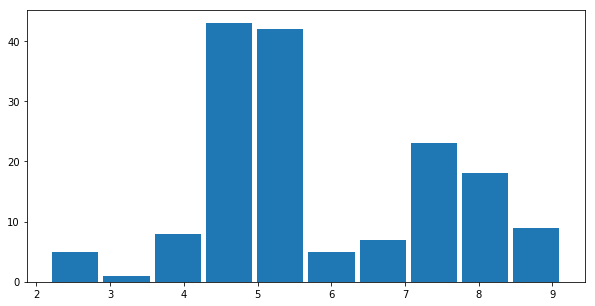

Previsão de Risco:


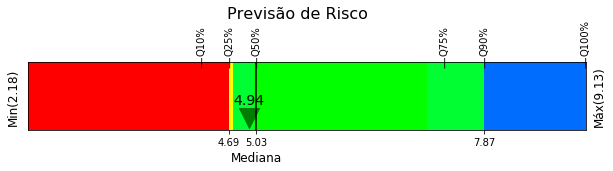




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NXR 150 BROS (06-15), COMPOSTO DE CORRENTE 428 X SM161 + COROA 40176 49Z + PINHAO 25115 17Z (CERTIFICADO NR. BR31512030) - ITEM: 71884
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.79
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'

Histograma por Decil:


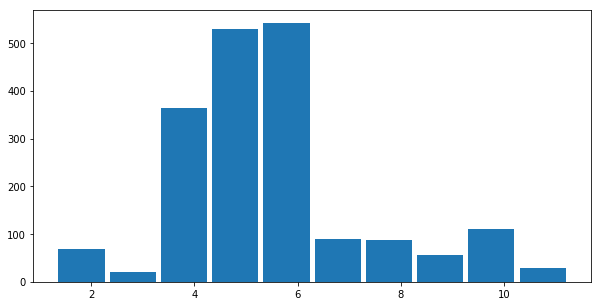

Previsão de Risco:


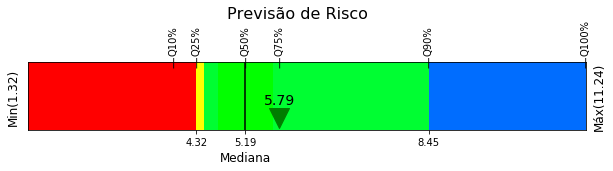




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM: KCJ004 - KIT TRANSMISSÃO PARA MOTOCICLETA MARCA SOTHIS CONTENDO CORRENTE, COROA E PINHÃO AÇO 1045 COMPATÍVEL BIZ 125 34Tx14T 106L 428H EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 37.60
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


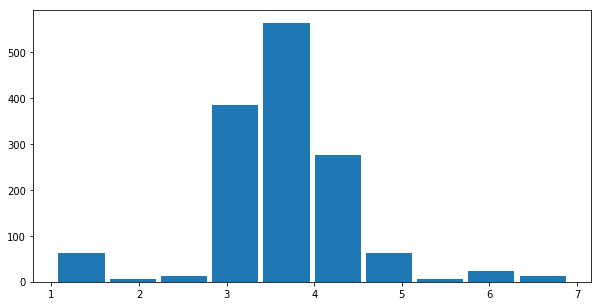

Previsão de Risco:


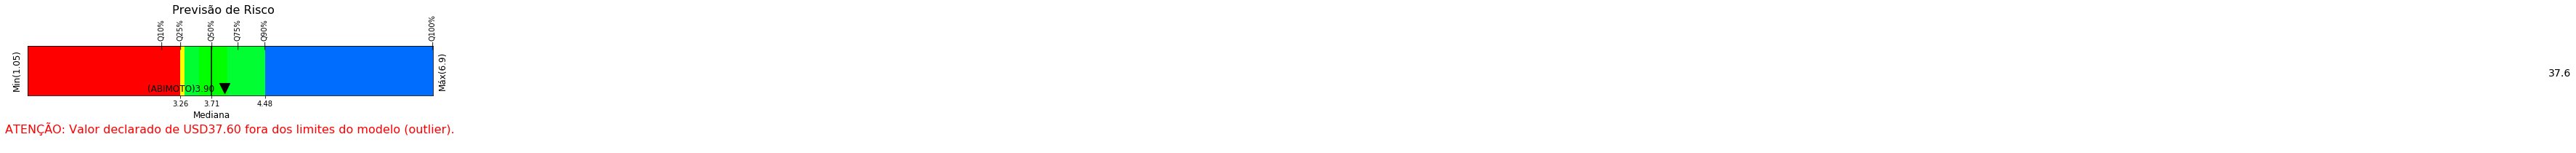




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item 07;Partes e peças para Motocicletas,Destaque 009-kit de Transmissão composto de corrente,coroa e pinhão;Tipo/modelo:1045-45D x 14D 428H x 118L STD/YBR 125 03-13/FACTOR 125 03-13;Nas Qdes:1.000unidades;Ref.:001-UNI-03800.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.14
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


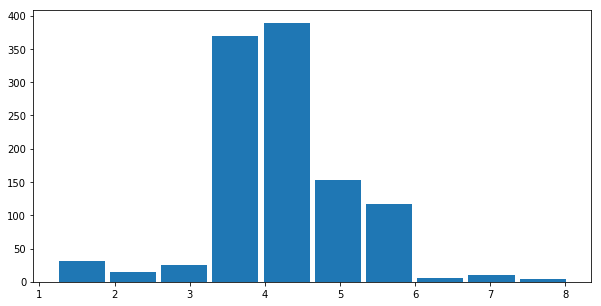

Previsão de Risco:


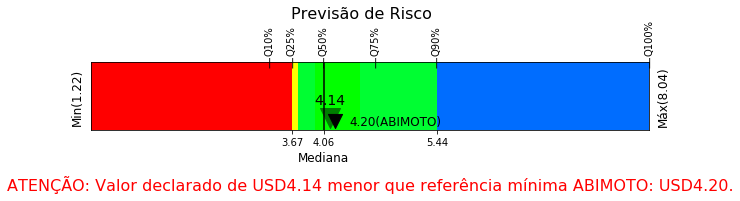




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: "073757 - KIT TRANSMISSÃO COMPOSTO DE CORRENTE, COROA E PINHÃO, PARA MOTOCICLETA, SENDO: KIT REL CROSSER 150 41/14 428HX122 ; MARCA: MAXX PREMIUM. "
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 3.57
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


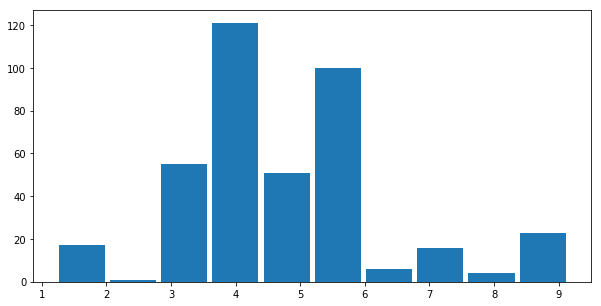

Previsão de Risco:


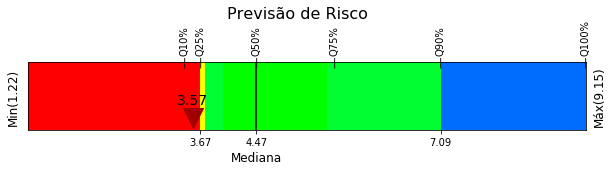




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE MEDIDAS: 520H X 104L, COROA C/PROT MEDIDAS: 38T, E PINHAO MEDIDAS: 13T. COMPATIVEL COM MOTOCICLETA(S) MODELO(S): XR 250 TORNADO. CODIGO: 5091.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TORNADO XR 250
Valor DI:  USD 5.83
Estatísticas:
qtd de registros:    258.000000
média simples:         6.673494
desvio padrão:         2.506848
valor mínimo:          1.670000
percentil 25%:         5.050000
percentil 50%:         6.728654
percentil 75%:         7.772000
valor máximo:         16.096330

Percentis:
  '10=1.67', '20=4.11', '25=5.05', '30=4.90', '40=5.36', '50=5.71'
  '60=6.73', '70=7.02', '75=7.77', '80=7.53', '90=8.07', '100=8.98'

Histograma por Decil:


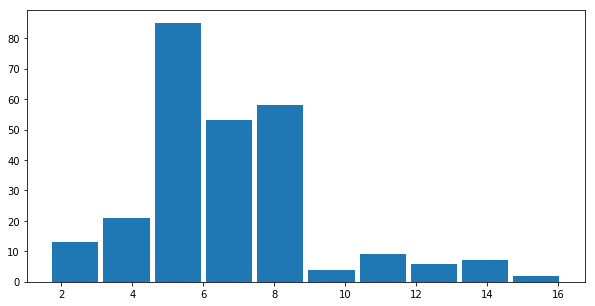

Previsão de Risco:


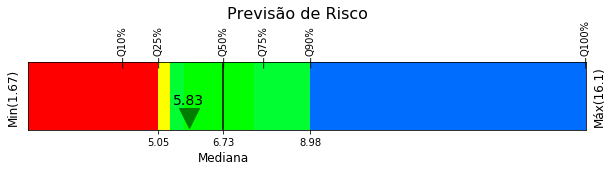




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TOP (1045) PARA MOTOCICLETAS XRE 300 (10-18), COMPOSTO DE CORRENTE 520 X M361 + COROA 40233 39Z + PINHAO 25140 13Z (CERTIFICADO NR. BR31512031) - ITEM: 91114
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XRE 300
Valor DI:  USD 14.15
Tabela de Referência ABIMOTO
Valor:      USD 6.00

Estatísticas:
qtd de registros:    490.000000
média simples:         7.326493
desvio padrão:         3.190781
valor mínimo:          1.324344
percentil 25%:         5.180000
percentil 50%:         7.090000
percentil 75%:         8.597748
valor máximo:         16.697000

Percentis:
  '10=1.32', '20=4.10', '25=5.18', '30=4.83', '40=5.53', '50=5.82'
  '60=7.09', '70=7.89', '75=8.60', '80=8.31', '90=8.89', '100=12.48'

Histograma por Decil:


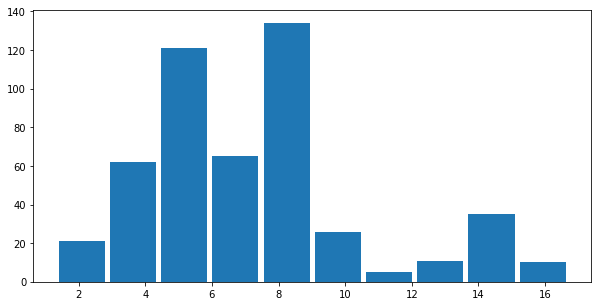

Previsão de Risco:


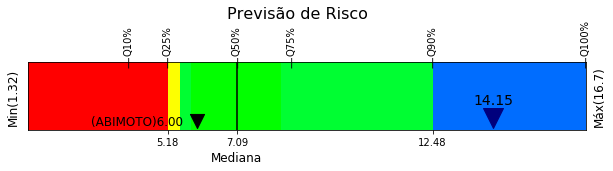




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETASCG 125 FAN (14-16)/ CG 125 CARGO (14-16)/ CG 125I FAN (16-18)/ CG125I CARGO (16-18), COMPOSTO DE CORRENTE 428 X SM118 +COROA S40282 43Z + PINHAO 25104 14Z (CERTIFICADO NR. BR31512030)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.20
Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'

Histograma por Decil:


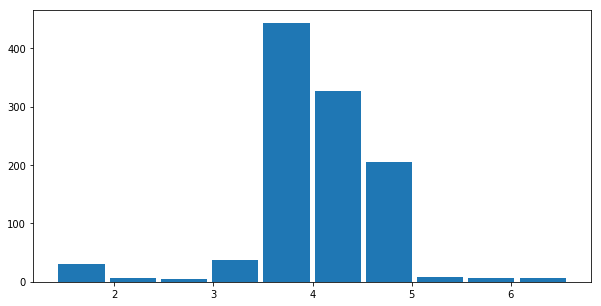

Previsão de Risco:


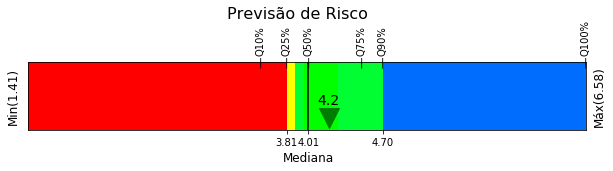




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO PARA MOTOCICLETA, CONTENDO CORRENTE, COROA E PINHAO, COMPATIVEL COM BROS 150 50D/17D428H*130L - REF.:LV118A04
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.34
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'

Histograma por Decil:


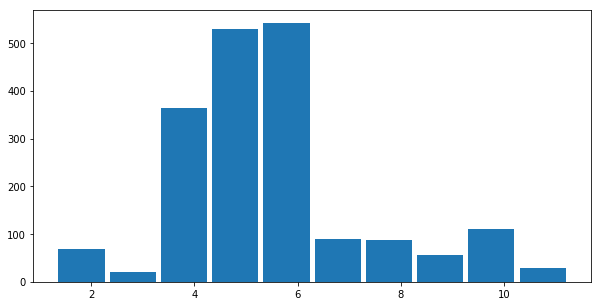

Previsão de Risco:


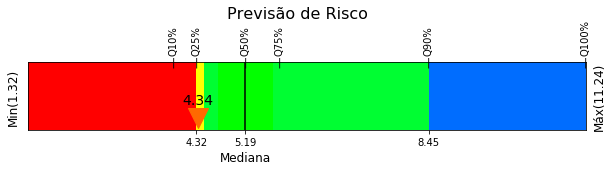




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT FAZER 150 H 41*14 - KIT DE TRANSMISSAO COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: FAZER 150, COROA/PINHAO: 41*14, CORRENTE DA MOTOCICLETA 428H E ELOS 126. REF. 14363C.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS150 150
Valor DI:  USD 3.02
Estatísticas:
qtd de registros:    428.000000
média simples:         4.645564
desvio padrão:         1.244155
valor mínimo:          1.106700
percentil 25%:         3.763200
percentil 50%:         4.598000
percentil 75%:         5.654700
valor máximo:          7.800000

Percentis:
  '10=1.11', '20=3.46', '25=3.76', '30=3.69', '40=3.84', '50=4.19'
  '60=4.60', '70=5.12', '75=5.65', '80=5.49', '90=5.68', '100=5.83'

Histograma por Decil:


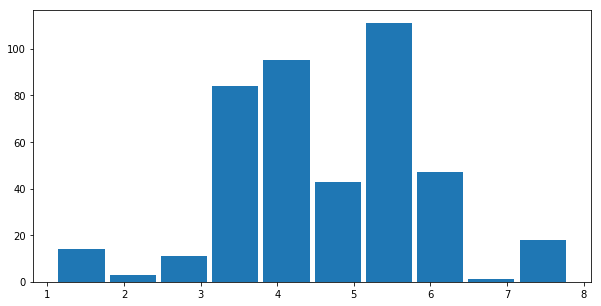

Previsão de Risco:


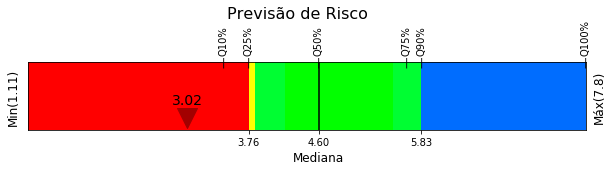




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS YBR 125 (03-08)/ YBR 125 FACTOR (03-16), COMPOSTO DE CORRENTE 428 X SM118 + COROA S41550 45Z + PINHAO 26571 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71815
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.06
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


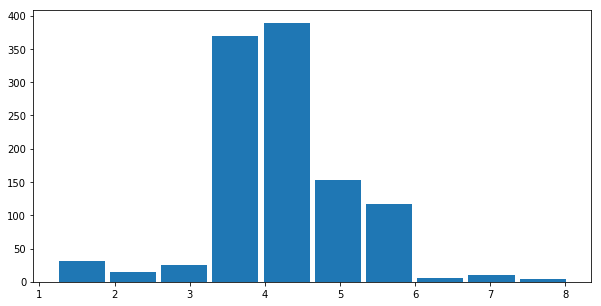

Previsão de Risco:


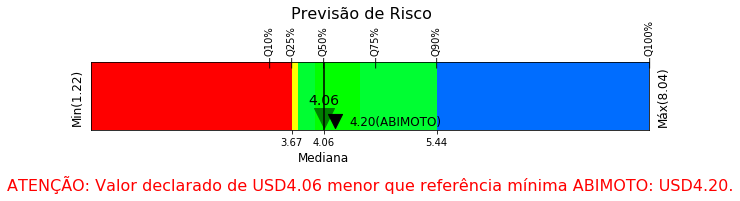




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NX-4 FALCON 400 (99-08)/ NX 400I FALCON (13-15) , COMPOSTO DE CORRENTE 520 X M136 + COROA 40041 40Z + PINHAO 25072 15Z (CERTIFICADO NR. BR31512031) - ITEM: 71746
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NX 400 FALCON
Valor DI:  USD 7.79
Estatísticas:
qtd de registros:    162.000000
média simples:         7.444776
desvio padrão:         2.915170
valor mínimo:          1.431723
percentil 25%:         5.600000
percentil 50%:         7.792996
percentil 75%:         8.500000
valor máximo:         16.666250

Percentis:
  '10=1.43', '20=4.41', '25=5.60', '30=5.47', '40=5.75', '50=6.27'
  '60=7.79', '70=8.00', '75=8.50', '80=8.42', '90=8.69', '100=10.50'

Histograma por Decil:


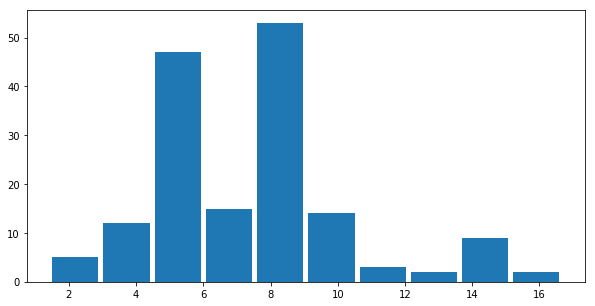

Previsão de Risco:


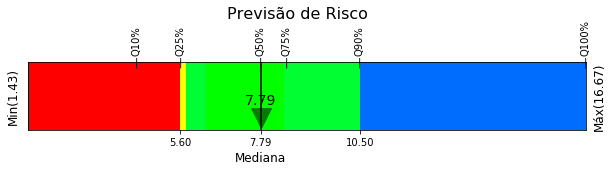




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 880474 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, UTILIZADO NAS MOTOS XRE300 C/RET 1045 - MARCA KMC GOLD
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: HONDA XRE 300
Valor DI:  USD 12.96
Tabela de Referência ABIMOTO
Valor:      USD 9.00

Estatísticas:
qtd de registros:    90.000000
média simples:        9.240015
desvio padrão:        3.081593
valor mínimo:         4.205900
percentil 25%:        6.920000
percentil 50%:        9.770000
percentil 75%:       11.600000
valor máximo:        16.696875

Percentis:
  '10=4.21', '20=4.32', '25=6.92', '30=6.26', '40=7.22', '50=9.21'
  '60=9.77', '70=10.26', '75=11.60', '80=11.36', '90=11.85', '100=12.89'

Histograma por Decil:


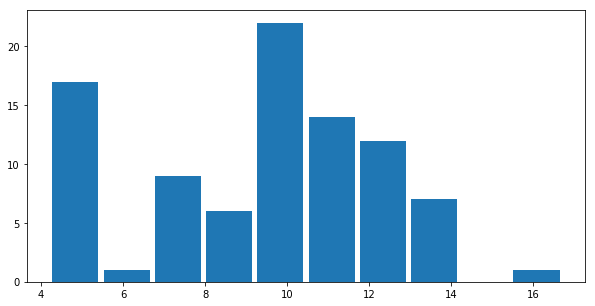

Previsão de Risco:


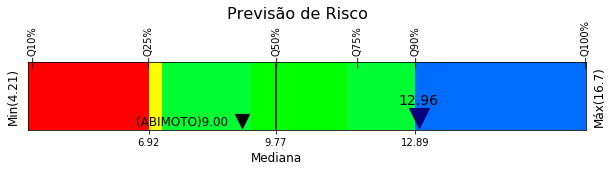




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGEM DE TRANSMISSAO EM AÇO, SENDO: KIT COROA, PINHAO E CORRENTE PARA MOTOCICLETAS MODELO - REF: KR-TITAN 150 - 43TX16TX428HX118L
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.56
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


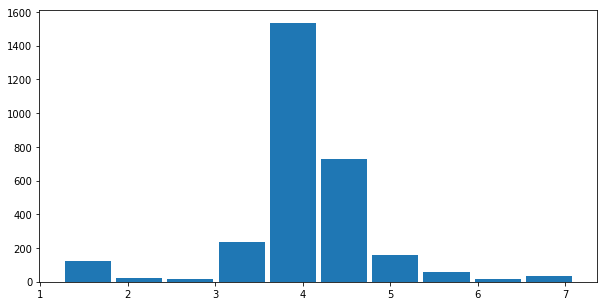

Previsão de Risco:


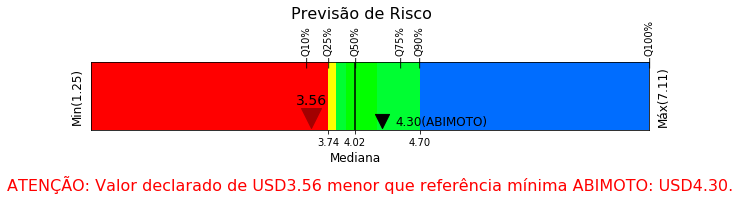




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 10674 - KIT TRANSMISSÃO PARA MOTOCICLETA CONTENDO CORRENTE, COROA E PINHÃO MARCA TMP AÇO 1045 COMPATIVEL WEB 100 36Tx14T 108L 428H, EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 38.64
Estatísticas:
qtd de registros:    219.000000
média simples:         3.805657
desvio padrão:         1.038534
valor mínimo:          1.107000
percentil 25%:         3.281631
percentil 50%:         3.573000
percentil 75%:         4.580000
valor máximo:          5.638000

Percentis:
  '10=1.11', '20=2.89', '25=3.28', '30=3.20', '40=3.35', '50=3.46'
  '60=3.57', '70=3.91', '75=4.58', '80=4.53', '90=4.80', '100=5.29'

Histograma por Decil:


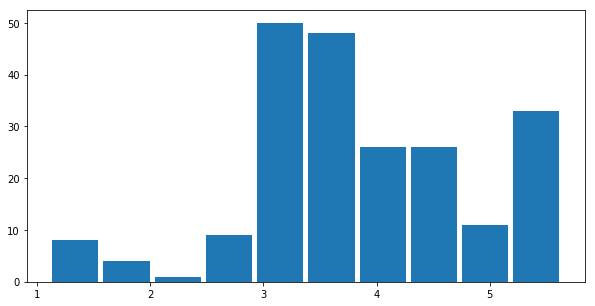

Previsão de Risco:


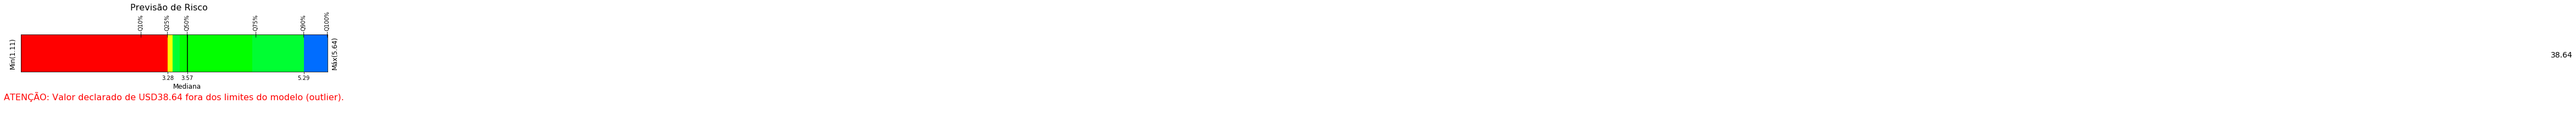




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 1104996 - DAROM / Kit de transmissao 520 - 1104996 - CB 250 TWISTER / Contendo: 1 Coroa 1800650 + 1 Pinhao 1800623 + 1 Corrente 1105016 / GTIN:7909201030508. CERTIFICADO NO: 16K-0005.01-02
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 5.99
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'

Histograma por Decil:


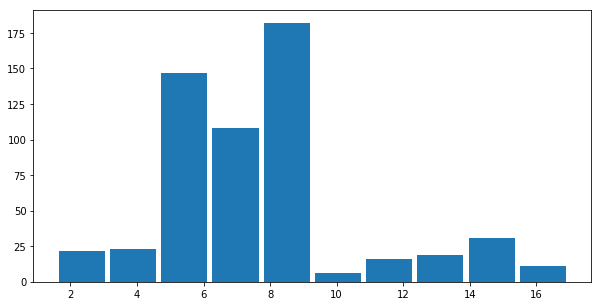

Previsão de Risco:


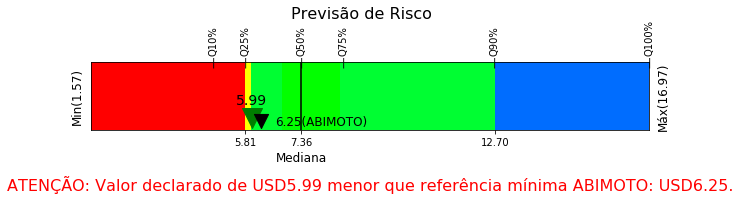




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (00-04)/ CG 125 FAN (05-08)/ CG 125 TITAN (00-04), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40038 44Z + PINHAO 25002 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71790
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.09
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


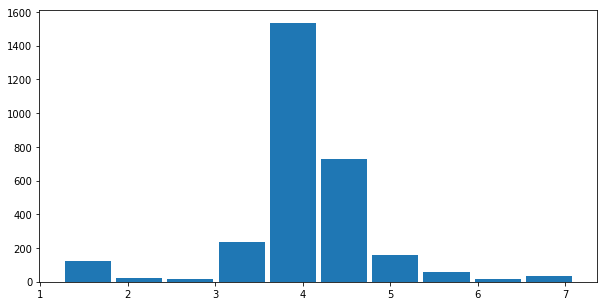

Previsão de Risco:


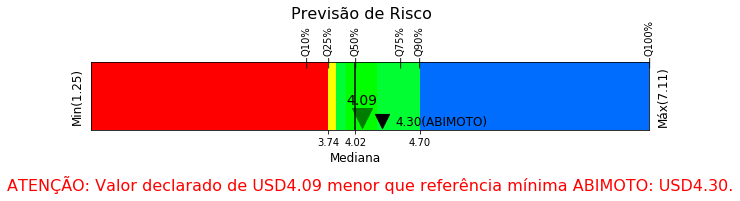




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 1000235WR - KIT TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO, PARA MOTOCICLETA MARCA WR COMPATÍVEL YBR 125 03/08/FACTOR 43T-14T/428H 118L EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 33.45
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


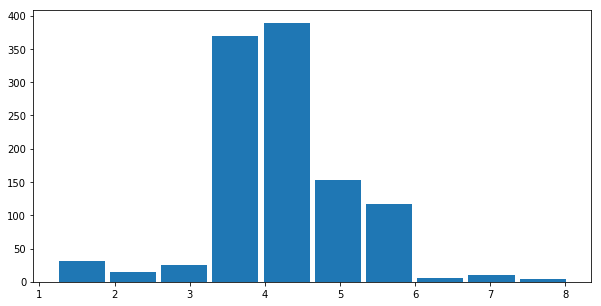

Previsão de Risco:


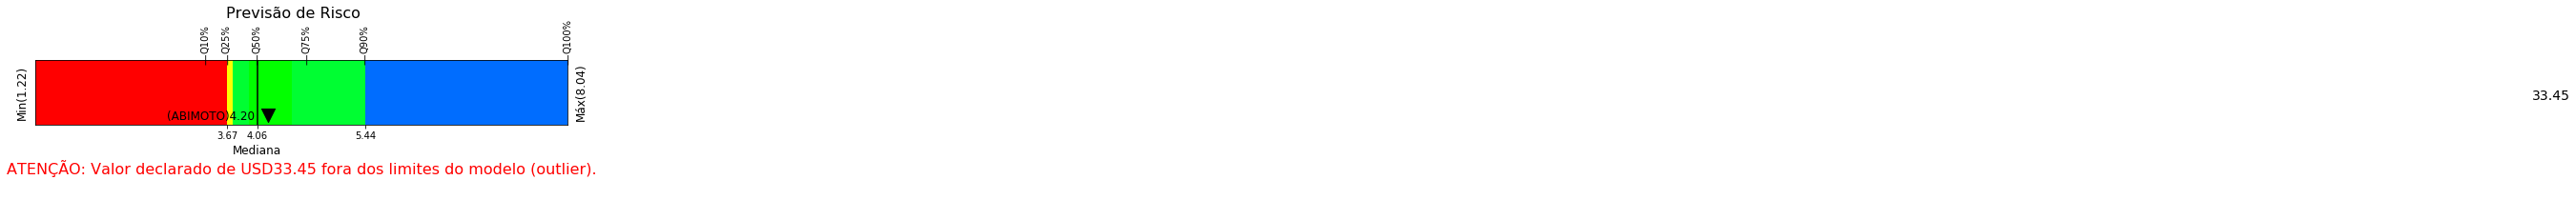




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, MODELO: KIT YBR 125 03/09 FACTOR 45X14 428HX118L.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.27
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


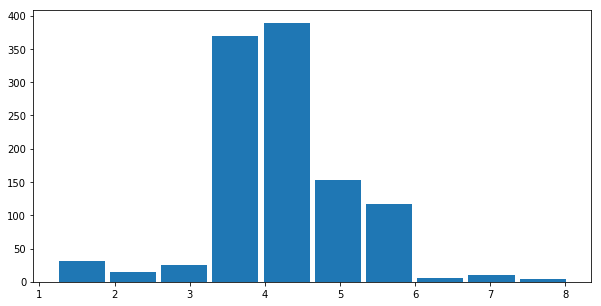

Previsão de Risco:


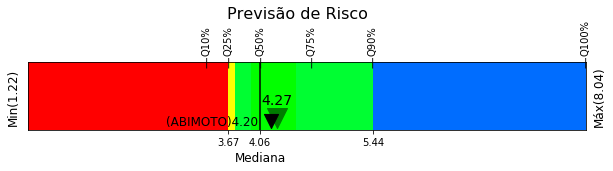




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT 250 FAZER H 45*15 - KIT DE TRANSMISSAO COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: 250 FAZER, COROA/PINHAO: 45*15, CORRENTE DA MOTOCICLETA 428H E ELOS 132. REF. 55520C.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS250 250
Valor DI:  USD 4.04
Tabela de Referência ABIMOTO
Valor:      USD 4.50

Estatísticas:
qtd de registros:    466.000000
média simples:         5.571051
desvio padrão:         1.735652
valor mínimo:          1.467516
percentil 25%:         4.210000
percentil 50%:         5.372500
percentil 75%:         6.760000
valor máximo:         11.358313

Percentis:
  '10=1.47', '20=3.82', '25=4.21', '30=4.10', '40=4.35', '50=4.61'
  '60=5.37', '70=6.31', '75=6.76', '80=6.73', '90=6.89', '100=7.76'

Histograma por Decil:


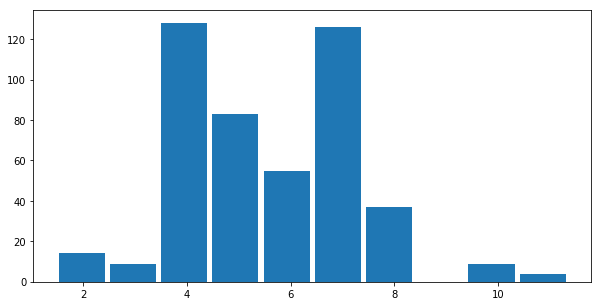

Previsão de Risco:


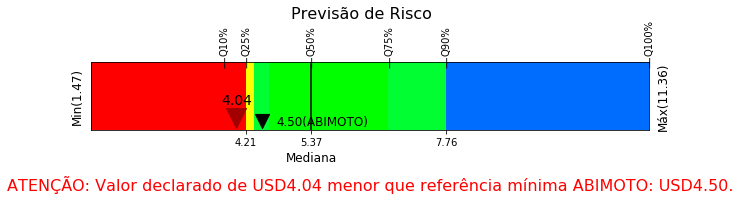




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 152006# KIT TRM STANDARD TEMPERADO COMPLETO. KIT DE TRANSMISSAO COMPOSTO COM CORRENTE, COROA E PINHAO P/ MOTO HONDA NXR 160 BROS ES/KS 15/... (48T+16T-428H+128L). MODELO: STD NXR 160 BROS
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 3.85
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'

Histograma por Decil:


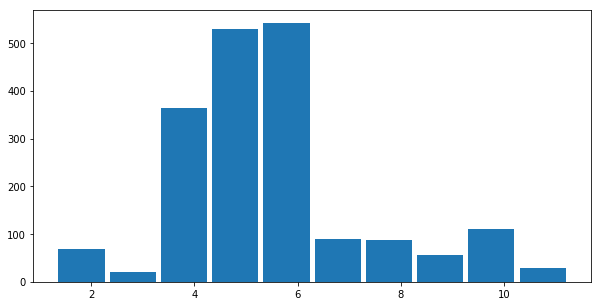

Previsão de Risco:


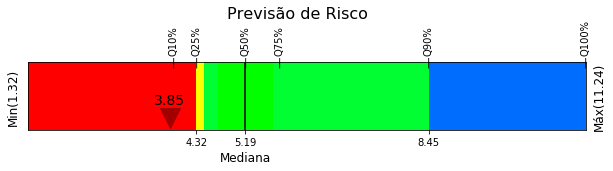




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES, SENDO, KIT DE TRANSMISSÃO TITANIUM (1045) PARA FACTOR 150( 16-18 ), COMPOSTO DE CORRENTE 428H X 124L, COROA 39Z, PINHÃO 14Z - ITEM 91176.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 5.65
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


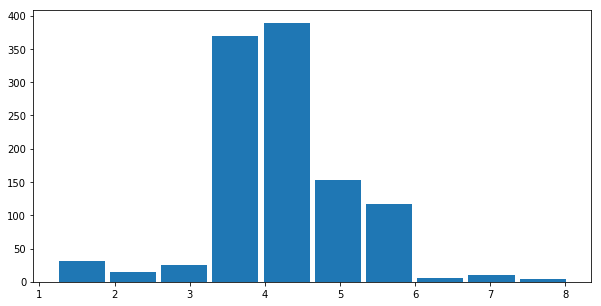

Previsão de Risco:


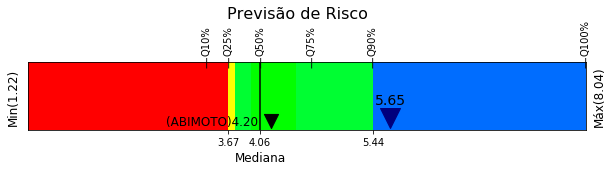




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: CPM12 - SEMI-KIT DE TRANSMISSÃO COMPOSTO DE COROA E PINHAO, SEM CORRENTE, PARA MOTOCICLETA, MODELO 45T/14T YBR 125, MARCA MOTOMO.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 1.66
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


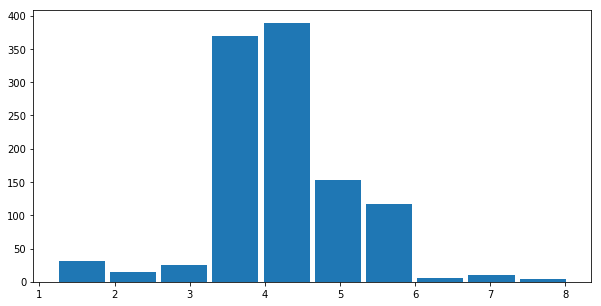

Previsão de Risco:


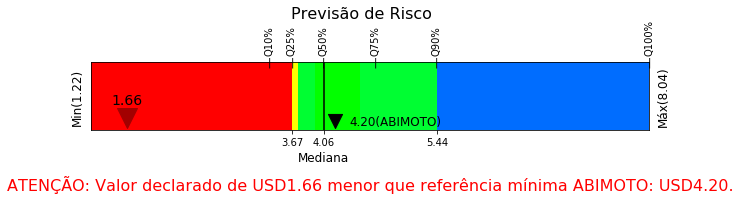




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 881740 - SEMI-KIT DE TRANSMISSAO COMPOSTO DE COROA E PINHAO SEM CORRENTE UTILIZADO NAS MOTOS YES125 01/16 - DENTES: 43/14 - MARCA: ALLEN
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUZUKI YES EN 125
Valor DI:  USD 1.63
Estatísticas:
qtd de registros:    207.000000
média simples:         4.088495
desvio padrão:         1.097315
valor mínimo:          1.256327
percentil 25%:         3.448000
percentil 50%:         3.845039
percentil 75%:         4.960000
valor máximo:          5.950000

Percentis:
  '10=1.26', '20=3.23', '25=3.45', '30=3.39', '40=3.49', '50=3.66'
  '60=3.85', '70=4.03', '75=4.96', '80=4.96', '90=5.38', '100=5.56'

Histograma por Decil:


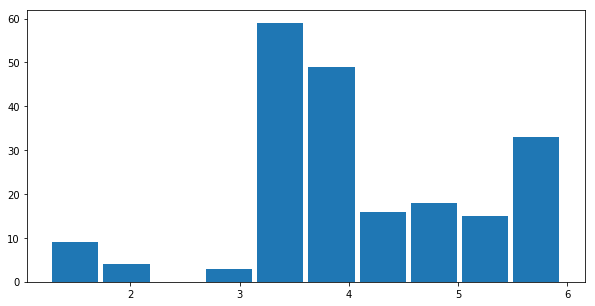

Previsão de Risco:


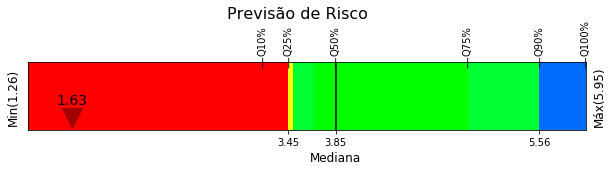




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA (EM AÇO 1045) E PINHAO (EM AÇO 1045) COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CG TITAN 2000 ATÉ 2008 (14-44Dx428Hx116). MARCA: CEVER.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.95
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


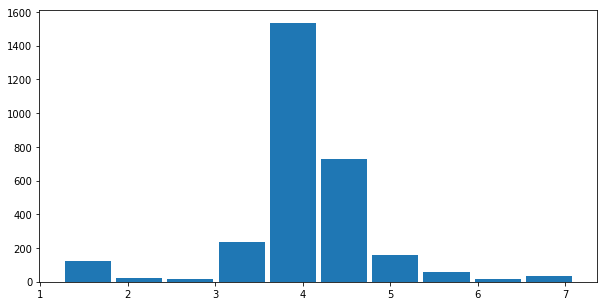

Previsão de Risco:


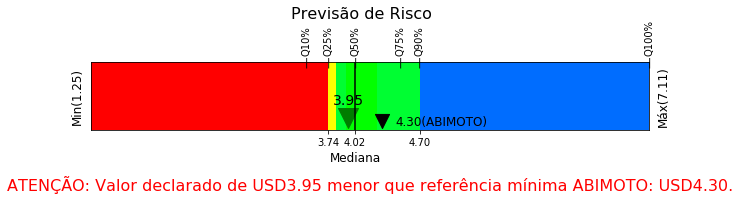




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 1250342 - DAROM / Kit de transmissão 428 - 1250342 - YES 125 / Contendo: 1 Coroa 1800532 + 1 Pinhão 1800503 + 1 Corrente 1105004 / GTIN:7909201030669 - CERTIFICADO NO: 16K-0005.01-01
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUZUKI YES EN 125
Valor DI:  USD 3.35
Estatísticas:
qtd de registros:    207.000000
média simples:         4.088495
desvio padrão:         1.097315
valor mínimo:          1.256327
percentil 25%:         3.448000
percentil 50%:         3.845039
percentil 75%:         4.960000
valor máximo:          5.950000

Percentis:
  '10=1.26', '20=3.23', '25=3.45', '30=3.39', '40=3.49', '50=3.66'
  '60=3.85', '70=4.03', '75=4.96', '80=4.96', '90=5.38', '100=5.56'

Histograma por Decil:


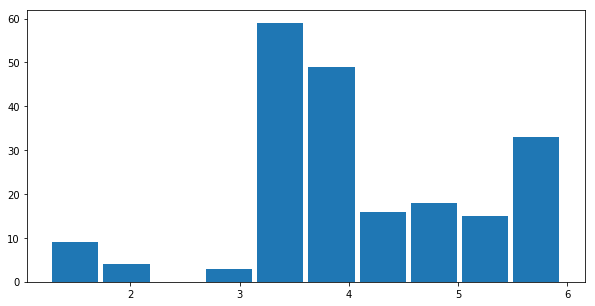

Previsão de Risco:


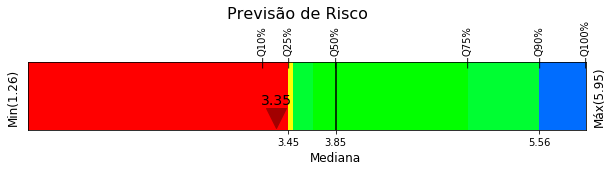




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: FAN 2009 - KIT TRANSMISSAO PARA MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHAO, PARA MOTOCICLETA, MODELO: 428Hx116L,43T/14T, MARCA MEGAVILLE DESTAQUE 002 KIT TRANSMISSAO PARA MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHAO
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 3.40
Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'

Histograma por Decil:


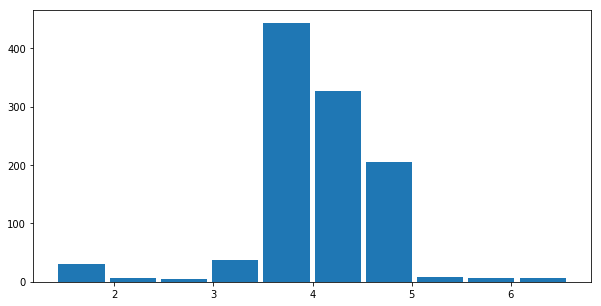

Previsão de Risco:


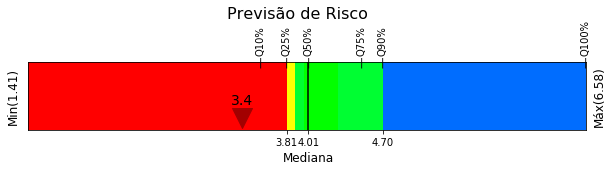




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM No: 91256 - KIT TRANSMISSAO EM ACO PARA MOTOCICLETAS (COMPOSTOPOR: CORRENTE, COROA E PINHAO) MARCA: RIFFEL, MODELOS: CG 160 TITAN(16-18) / CG 160 FAN (16-18) / CG 160 START (16-18) / CG 160 CARGO(16-17) 44Z X 15Z WITH ORING CHAIN 428HO X 118L -
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 10.01
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


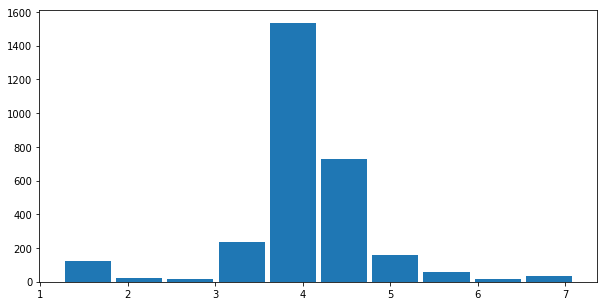

Previsão de Risco:


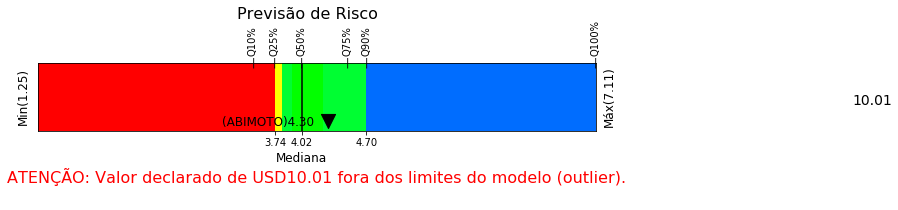




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TOP (1045) PARA MOTOCICLETAS CG 160 TITAN (16-19)/ CG 160 FAN (16-19) / CG 160 START (16-19) / CG 160 CARGO (16-19), COMPOSTO DE CORRENTE 428 X M351 + COROA 40307 44Z + PINHAO 25111 15Z (CERTIFICADO NR. BR31512030)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 8.21
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'

Histograma por Decil:


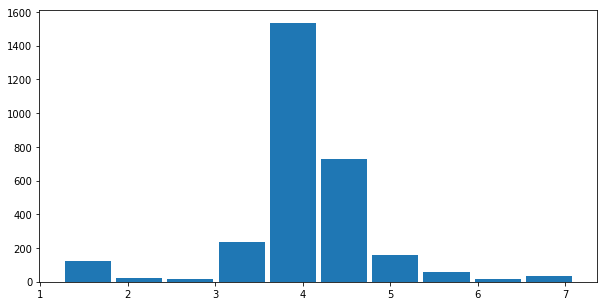

Previsão de Risco:


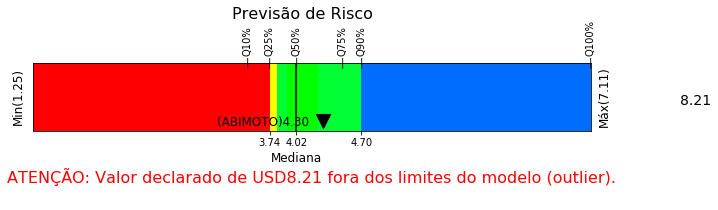




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 001-P21B-02200F - KIT DE TRANSMISSAO DO MOTOR DE MOTOCICLETA, COMPOSTO DE CORRENTE DE COMANDO, COROA E PINHAO, 1045 - 41D X 14D 428H X 122L STD. CROSSER 150 XTZ 150 2014 - 2017 001-P21B-02200F
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 4.24
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


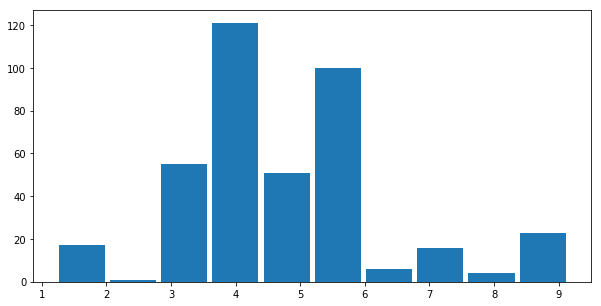

Previsão de Risco:


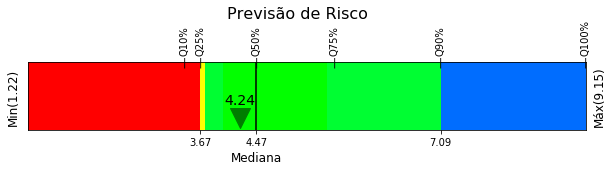




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO PARA MOTOCICLETA, CONTENDO CORRENTE, COROA E PINHAO, COMPATIVEL COM FAN 125 ES/KS 09 43D/14D428H*120L - REF.:LV118A08
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.01
Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'

Histograma por Decil:


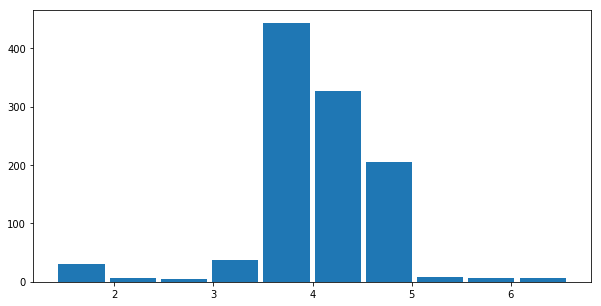

Previsão de Risco:


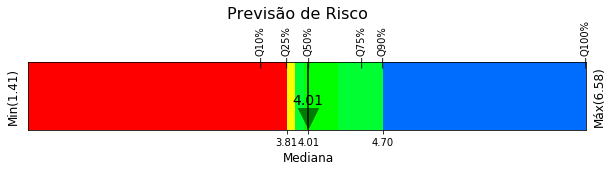




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CBX 250 TWISTER (01-08), COMPOSTO DE CORRENTE 520 X M136 + COROA 40067 37Z + PINHAO 25138 13Z (CERTIFICADO NR. BR31512031) - ITEM: 71761
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 7.74
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'

Histograma por Decil:


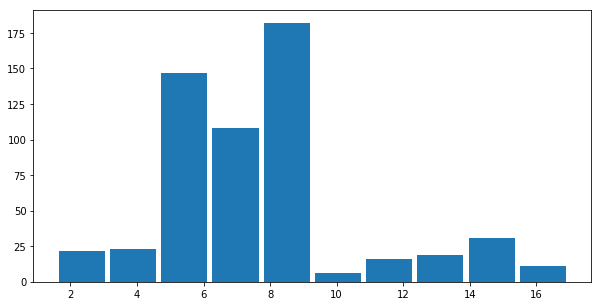

Previsão de Risco:


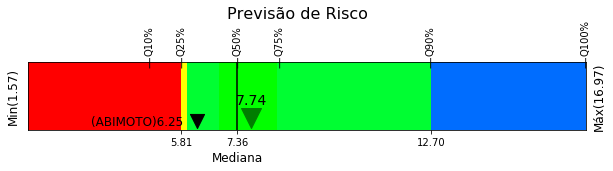




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 80393 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA XTZ 125, MARCA ALLEN.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ 125
Valor DI:  USD 3.92
Estatísticas:
qtd de registros:    314.000000
média simples:         4.871234
desvio padrão:         1.396000
valor mínimo:          1.559612
percentil 25%:         3.930000
percentil 50%:         4.409778
percentil 75%:         5.950000
valor máximo:          9.578000

Percentis:
  '10=1.56', '20=3.75', '25=3.93', '30=3.86', '40=3.97', '50=4.30'
  '60=4.41', '70=5.14', '75=5.95', '80=5.87', '90=5.99', '100=6.29'

Histograma por Decil:


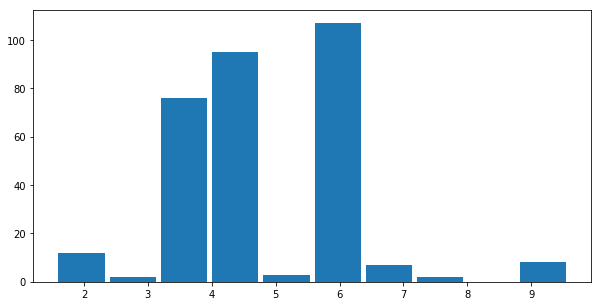

Previsão de Risco:


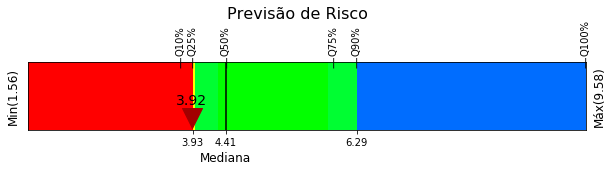




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 1104996 -DAROM / Kit de transmissão 520 - 1104996 - CB 250 Coroa TWISTER / Contendo: 1 Coroa 1800650 1 Pinhão 1800623 1 Corrente 1105016 / GTIN:7909201030508. Certificado: 16K-0005.01-02
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 5.99
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'

Histograma por Decil:


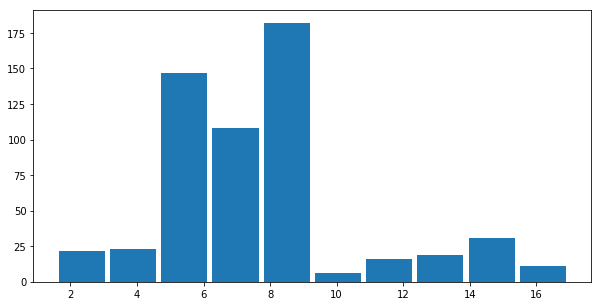

Previsão de Risco:


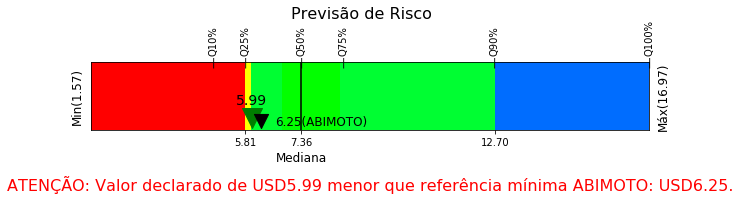




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item 05;Partes e peças para Motocicletas,Destaque 002-Kit de Transmissão composto de corrente,coroa e pinhão;p/modelo;KIT CG 125 CARGO(09-13)/CG 125 FAN(09-13)43Z X 14Z WITH CHAIN 428H X 116L-TITANIUM(1045);Nas Qdes;1500unidades;Ref.;91048.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.70
Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'

Histograma por Decil:


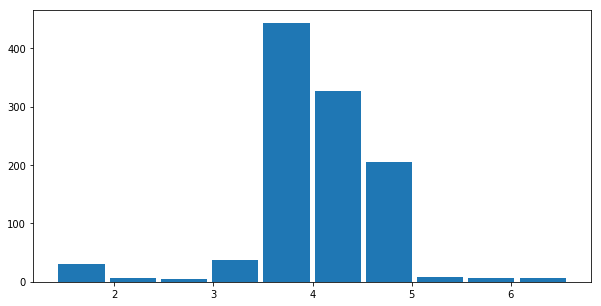

Previsão de Risco:


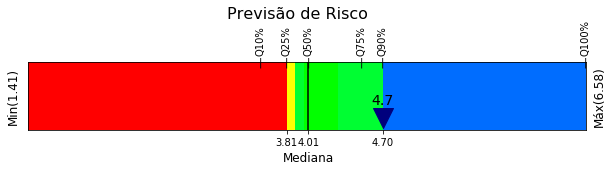




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10540016 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: CB300(13D/37D/110) MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CB 300R 300 CB300
Valor DI:  USD 9.19
Estatísticas:
qtd de registros:    392.000000
média simples:         8.343206
desvio padrão:         3.299917
valor mínimo:          1.574895
percentil 25%:         5.906363
percentil 50%:         8.213024
percentil 75%:         9.517636
valor máximo:         17.649038

Percentis:
  '10=1.57', '20=4.95', '25=5.91', '30=5.69', '40=6.35', '50=7.50'
  '60=8.21', '70=8.83', '75=9.52', '80=9.13', '90=9.82', '100=14.50'

Histograma por Decil:


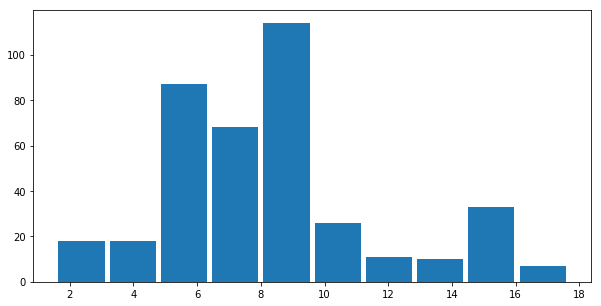

Previsão de Risco:


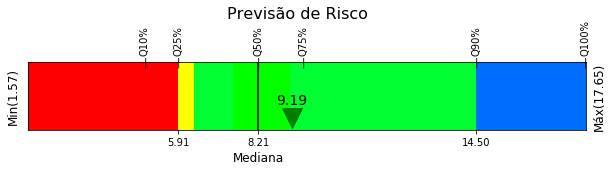

In [17]:
riscoValor(dfimp.iloc[1:])